In [1]:
import sys
import os
%matplotlib inline

In [4]:
# get current working directory
os.getcwd()
# change directory
os.chdir('../')
os.getcwd()

'c:\\Users\\pnaghs1\\Documents\\Github\\GraphModels'

## Load data

In [5]:
import csv
import numpy as np
# load CSV dataset
smlstr = []
activity = []
add_comp_descriptors = True
with open('data/activityCoeff_MD_revised.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if add_comp_descriptors:
            # print(row[0:-1])
            # print(row[-1])
            smlstr.append(row[0:-1])
            activity.append(row[-1])
        else:
            smlstr.append(row[0])
            activity.append(row[1])

smlstr = np.asarray(smlstr)
activity = np.asarray(activity, dtype="float")
dataset_size = len(activity)
all_ind = np.arange(dataset_size)

In [6]:
smlstr

array([['CC(CC(CC(CC(CC(CC(CC(CC(CC(C)c1ccccn1)c1cccc[n+]1C)c1ccccc1)c1cccc[n+]1C)c1ccccc1)c1cccc[n+]1C)c1ccccc1)c1ccccn1)c1ccccn1',
        '[I-].[K+]', '6', ..., '4.15', '5.8', '1.9'],
       ['CC(CC(CC(CC(CC(CC(CC(CC(CC(C)c1ccccn1)c1cccc[n+]1C)c1ccccc1)c1cccc[n+]1C)c1ccccc1)c1cccc[n+]1C)c1ccccc1)c1ccccn1)c1ccccn1',
        '[I-].[K+]', '6', ..., '4.15', '5.8', '2.0'],
       ['CC(CC(CC(CC(CC(CC(CC(CC(CC(C)c1ccccn1)c1cccc[n+]1C)c1ccccc1)c1cccc[n+]1C)c1ccccc1)c1cccc[n+]1C)c1ccccc1)c1ccccn1)c1ccccn1',
        '[I-].[K+]', '6', ..., '4.15', '5.6', '2.2'],
       ...,
       ['CC1C(=O)OCCOCCOCCOCCOC(=O)C(C)C(C(C(=O)NC(C)(C)CS(=O)(=O)[O-])C(C(=O)NC(C)(C)CS(=O)(=O)[O-])C(C(=O)NC(C)(C)CS(=O)(=O)[O-])C(C)C(=O)NC(C)(C)CS(=O)(=O)[O-])C(=O)OCCOCCOCCOCCOC(=O)C1C',
        '[Cl-].[Na+]', '24', ..., '2.35', '8.3', '0.18'],
       ['CC1C(=O)OCCOCCOCCOCCOC(=O)C(C)C(C(C(=O)NC(C)(C)CS(=O)(=O)[O-])C(C(=O)NC(C)(C)CS(=O)(=O)[O-])C(C(=O)NC(C)(C)CS(=O)(=O)[O-])C(C)C(=O)NC(C)(C)CS(=O)(=O)[O-])C(=O)OCCOCCOCC

## Graph Model

In [ ]:
import torch
import dgl
from dgllife.utils import BaseAtomFeaturizer,CanonicalAtomFeaturizer,CanonicalBondFeaturizer 
from dgllife.utils import mol_to_graph,mol_to_bigraph,mol_to_complete_graph,smiles_to_complete_graph
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
from sklearn.preprocessing import MinMaxScaler

### Load saved model

In [8]:
import dgl
import torch
from dgl.nn.pytorch import GraphConv

import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F

#from src.createGraph import collates, collate_add, collate_multi, collate_multi_add 

class GCNReg_binary_add(nn.Module):
    def __init__(self, in_dim, extra_in_dim, hidden_dim, n_classes, rdkit_features=False, saliency=False):
        super(GCNReg_binary_add, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.rdkit_features = rdkit_features
        if self.rdkit_features:
            self.classify1 = nn.Linear(hidden_dim*2+extra_in_dim*2, hidden_dim*2+extra_in_dim*2)
            self.classify2 = nn.Linear(hidden_dim*2+extra_in_dim*2, hidden_dim)
        else:
            self.classify1 = nn.Linear(hidden_dim*2+extra_in_dim, hidden_dim*2+extra_in_dim)
            self.classify2 = nn.Linear(hidden_dim*2+extra_in_dim, hidden_dim)
        
        self.classify3 = nn.Linear(hidden_dim, hidden_dim)
        self.classify4 = nn.Linear(hidden_dim, n_classes)
        self.saliency = saliency
    
    def forward(self, g, descriptors):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.

        if torch.cuda.is_available():
            h1 = g[0].ndata['h'].float().cuda()
            h2 = g[1].ndata['h'].float().cuda()
        else:
            h1 = g[0].ndata['h'].float()
            h2 = g[1].ndata['h'].float()

        if self.saliency == True:
            h1.requires_grad = True
            h2.requires_grad = True

        h1 = F.relu(self.conv1(g[0], h1))
        h1 = F.relu(self.conv2(g[0], h1))
        h2 = F.relu(self.conv1(g[1], h2))
        h2 = F.relu(self.conv2(g[1], h2))

        g[0].ndata['h'] = h1
        g[1].ndata['h'] = h2
        # Calculate graph representation by averaging all the node representations.
        hg1 = dgl.mean_nodes(g[0], 'h')
        hg2 = dgl.mean_nodes(g[1], 'h')

        # Now concatenate along dimension 1 (columns)
        hg = torch.cat((hg1, hg2), dim=1)

        #hg = torch.cat((hg, descriptors.to(torch.float32)), dim=1)
        # Check if descriptors is a tensor, and ensure it has the same dtype as hg
        if torch.is_tensor(descriptors):
            hg = torch.cat((hg, descriptors.to(torch.float32)), dim=1)
            #hg = torch.cat((hg, descriptors[0].to(torch.float32), descriptors[1].to(torch.float32)), dim=1)
        else:
            # descriptors = torch.tensor(descriptors, dtype=torch.float32)
            # hg = torch.cat((hg, descriptors), dim=1)
            pass
            #hg = torch.cat((hg, torch.tensor(descriptors[0], dtype=torch.float32), torch.tensor(descriptors[1], dtype=torch.float32)), dim=1)


        output = F.relu(self.classify1(hg))
        output = F.relu(self.classify2(output))
        output = F.relu(self.classify3(output))
        output = self.classify4(output)

        if self.saliency == True:
            output.backward()
            return output, h1.grad, h2.grad
        else:
            return output

In [9]:
model_path = "models/EarlyStop_rd42_nonRDkit_withMD_0005_256_pn__actCoeff/"

model_name = "ep1000bs10lr0.0005kf11hu256cvid10.pth.tar"

checkpoint = torch.load("{}/{}".format(model_path, model_name))

model = GCNReg_binary_add(in_dim=74, extra_in_dim=14, hidden_dim=256, rdkit_features=False, n_classes=1, saliency=False)

model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [10]:
import pickle  

In [11]:
path = 'models/EarlyStop_rd42_nonRDkit_withMD_0005_256_pn__actCoeff/' 

smlstr_train = pickle.load(open(f"{path}/smlstr_train.p","rb"))
smlstr_test = pickle.load(open(f"{path}/smlstr_test.p","rb"))

activity_train = pickle.load(open(f"{path}/activity_train.p","rb"))
activity_test = pickle.load(open(f"{path}/activity_test.p","rb"))

In [12]:
from src.createGraph import multi_graph_dataset

In [13]:
train_full_dataset = multi_graph_dataset(smlstr_train,activity_train, add_features = True, rdkit_descriptor = False)
test_dataset = multi_graph_dataset(smlstr_test,activity_test, add_features = True, rdkit_descriptor = False)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [14]:
from src.createGraph import collate_multi_non_rdkit
from src.NNgraph import GCNReg_binary_add
import torch
import torch.nn as nn
import glob
import os

train_loader = torch.utils.data.DataLoader(train_full_dataset, batch_size=1, collate_fn=collate_multi_non_rdkit, shuffle=False)  

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, collate_fn=collate_multi_non_rdkit, shuffle=False)  

In [15]:
def get_predictions(data_loader):

    y_pred = []
    y_true = []

    for i, data in enumerate(data_loader):
        (graph1, graph2, descriptor, label) = data
            
        label = label.view(-1,1)
        output = model((graph1, graph2), descriptor)
        y_true.append(label.float())
        y_pred.append(output)


    y_true = [[t.cpu().detach().numpy()[0] for t in sublist][0] for sublist in y_true]

    y_pred = [t.cpu().detach().numpy()[0][0] for t in y_pred if t.grad_fn is not None]
   

    return y_true, y_pred

In [16]:
tar_files = glob.glob(path + '/*.tar')

checkpoints = {}
models = {}
train = {}
test = {}

for tar_file in tar_files:

    # load checkpoint
    checkpoint = torch.load(tar_file)
    checkpoint_name = os.path.basename(tar_file).replace('.tar', '')
    checkpoints[checkpoint_name] = checkpoint

    # load model with checkpoint
    try:
        model.load_state_dict(checkpoint['state_dict'])
    except:
        model.load_state_dict(checkpoint['model_state_dict'])
    models[checkpoint_name] = model

    model.eval()

    train[checkpoint_name] = get_predictions(train_loader)
    test[checkpoint_name] = get_predictions(test_loader)

In [17]:
train.keys()

dict_keys(['ep1000bs10lr0.0005kf11hu256cvid0.pth', 'ep1000bs10lr0.0005kf11hu256cvid0es.pth', 'ep1000bs10lr0.0005kf11hu256cvid1.pth', 'ep1000bs10lr0.0005kf11hu256cvid10.pth', 'ep1000bs10lr0.0005kf11hu256cvid10es.pth', 'ep1000bs10lr0.0005kf11hu256cvid1es.pth', 'ep1000bs10lr0.0005kf11hu256cvid2.pth', 'ep1000bs10lr0.0005kf11hu256cvid2es.pth', 'ep1000bs10lr0.0005kf11hu256cvid3.pth', 'ep1000bs10lr0.0005kf11hu256cvid3es.pth', 'ep1000bs10lr0.0005kf11hu256cvid4.pth', 'ep1000bs10lr0.0005kf11hu256cvid4es.pth', 'ep1000bs10lr0.0005kf11hu256cvid5.pth', 'ep1000bs10lr0.0005kf11hu256cvid5es.pth', 'ep1000bs10lr0.0005kf11hu256cvid6.pth', 'ep1000bs10lr0.0005kf11hu256cvid6es.pth', 'ep1000bs10lr0.0005kf11hu256cvid7.pth', 'ep1000bs10lr0.0005kf11hu256cvid7es.pth', 'ep1000bs10lr0.0005kf11hu256cvid8.pth', 'ep1000bs10lr0.0005kf11hu256cvid8es.pth', 'ep1000bs10lr0.0005kf11hu256cvid9.pth', 'ep1000bs10lr0.0005kf11hu256cvid9es.pth'])

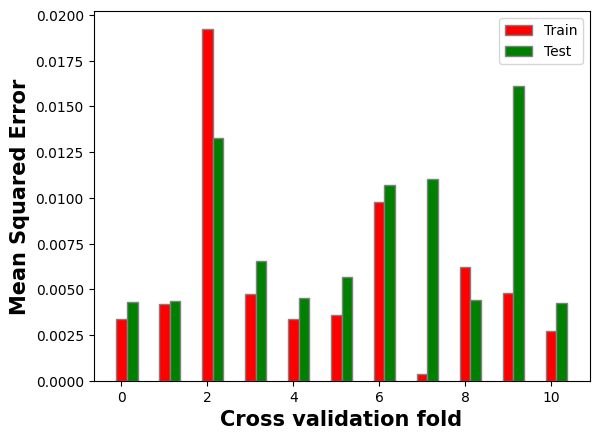

In [18]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
# Compute the MSE for each key
mse_values_train = {}
mse_values_test = {}

for key in range(11):  # Assuming keys are integers from 0 to 10
    
    exp_train = train[f'ep1000bs10lr0.0005kf11hu256cvid{key}.pth'][0]
    pred_train = train[f'ep1000bs10lr0.0005kf11hu256cvid{key}.pth'][1]
    exp_test = test[f'ep1000bs10lr0.0005kf11hu256cvid{key}.pth'][0]
    pred_test = test[f'ep1000bs10lr0.0005kf11hu256cvid{key}.pth'][1]

    mse_values_train[key] = mean_squared_error(exp_train, pred_train)
    mse_values_test[key] = mean_squared_error(exp_test, pred_test)


# Prepare the data for plotting
keys_train = list(mse_values_train.keys())
values_train = list(mse_values_train.values())

keys_test = list(mse_values_test.keys())
values_test = list(mse_values_test.values())

# Create the bar chart
# Set position of bar on X axis
barWidth = 0.25
br1 = np.arange(len(keys_train))
br2 = [x + barWidth for x in br1]
 
plt.bar(br1, values_train, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train')
plt.bar(br2, values_test, color ='g', width = barWidth,
        edgecolor ='grey', label ='Test')
 
plt.xlabel('Cross validation fold', fontweight ='bold', fontsize = 15)
plt.ylabel('Mean Squared Error', fontweight ='bold', fontsize = 15)

plt.legend()
plt.show()


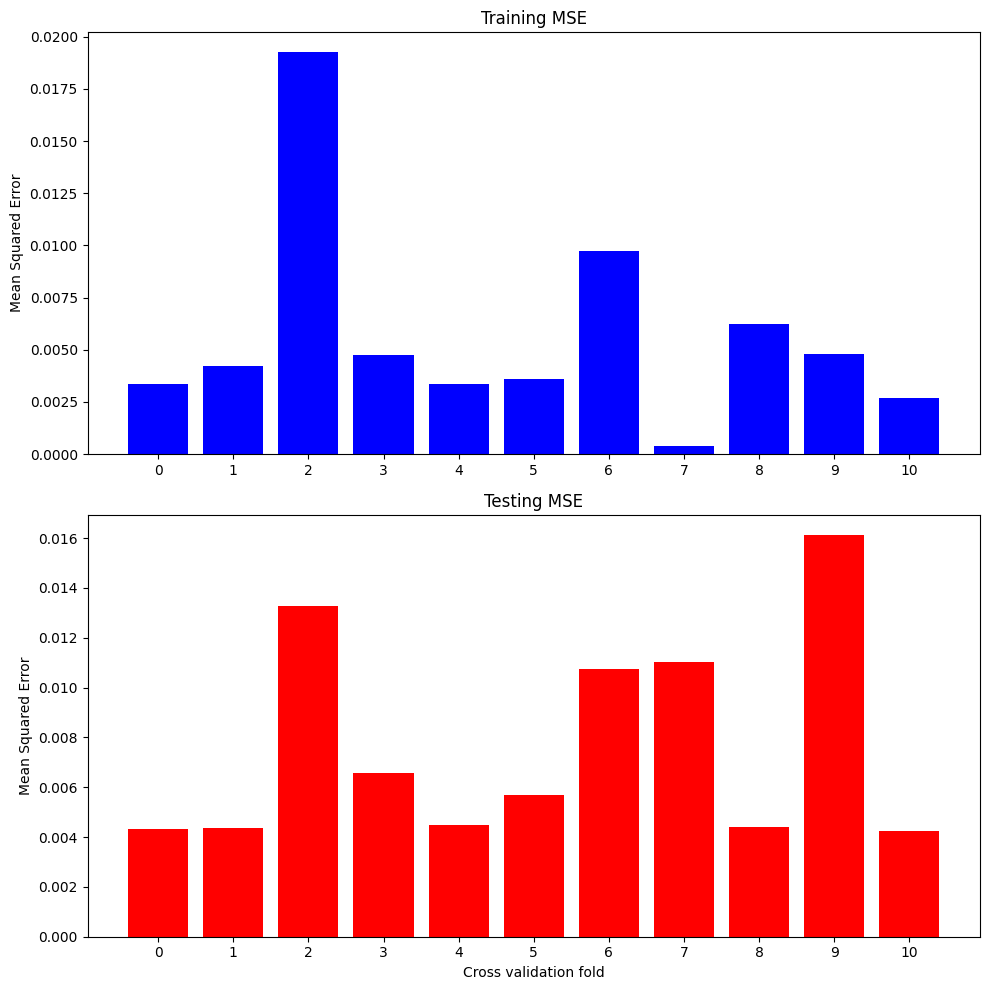

In [19]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

# Plot the train bar chart
axs[0].bar(keys_train, values_train, color='blue')
axs[0].set_ylabel('Mean Squared Error')
axs[0].set_title('Training MSE')
axs[0].set_xticks(range(11))  # Set x-ticks to ensure they match for both subplots
axs[0].set_xticklabels(keys_train)  # Set x-tick labels to match the keys

# Plot the test bar chart
axs[1].bar(keys_test, values_test, color='red')
axs[1].set_xlabel('Cross validation fold')
axs[1].set_ylabel('Mean Squared Error')
axs[1].set_title('Testing MSE')
axs[1].set_xticks(range(11))  # Set x-ticks to ensure they match for both subplots
axs[1].set_xticklabels(keys_test)  # Set x-tick labels to match the keys

# Show the plot
plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()

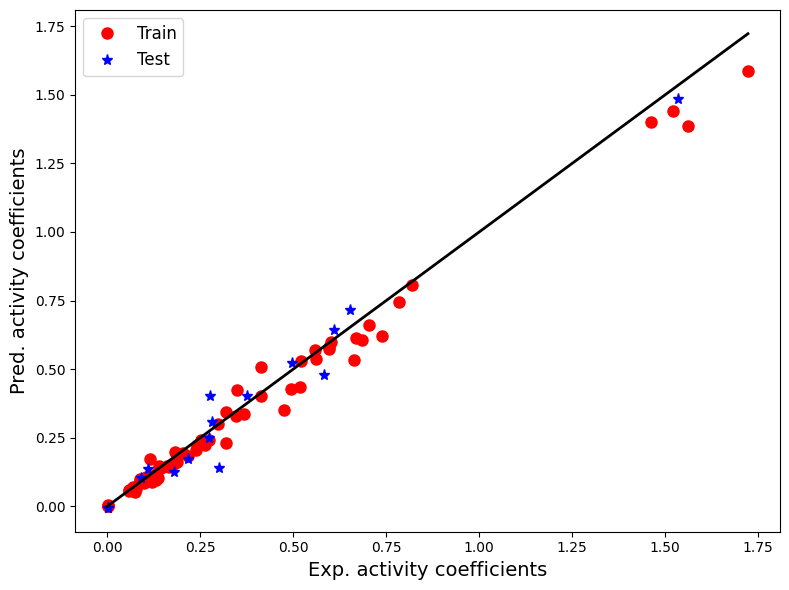

In [20]:
import matplotlib.pyplot as plt

# Define data key for clarity
data_key = 'ep1000bs10lr0.0005kf11hu256cvid10.pth'

# Load training and testing data
train_exp = train[data_key][0]
train_pred = train[data_key][1]
test_exp = test[data_key][0]  # This seems to be a mistake. It's the same as the train_exp. Should it be from another dataset?
test_pred = test[data_key][1]  # Similarly, this seems to be a mistake.

# Define plot parameters for better visibility
plt.figure(figsize=(8, 6))  # Define a larger figure size
plt.plot(train_exp, train_pred, 'ro', markersize=8, label='Train')
plt.plot(test_exp, test_pred, 'b*', markersize=8, label='Test')
plt.plot(
    [min(min(train_exp), min(train_pred)), max(max(train_exp), max(train_pred))],
    [min(min(train_exp), min(train_pred)), max(max(train_exp), max(train_pred))],
    'k-', linewidth=2
)

# Labels, title and legend
plt.xlabel('Exp. activity coefficients', fontsize=14)
plt.ylabel('Pred. activity coefficients', fontsize=14)
plt.legend(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Convert your data to NumPy arrays
train_exp = np.array(train_exp)
train_pred = np.array(train_pred)
test_exp = np.array(test_exp)
test_pred = np.array(test_pred)

# Calculate R^2
r2_train = r2_score(train_exp, train_pred)
r2_test = r2_score(test_exp, test_pred)

# Calculate MAE
mae_train = mean_absolute_error(train_exp, train_pred)
mae_test = mean_absolute_error(test_exp, test_pred)

# Calculate standard deviation
std_train = np.std(train_exp - train_pred)
std_test = np.std(test_exp - test_pred)

# Print the results
print(f"R^2 (Train): {r2_train}")
print(f"R^2 (Test): {r2_test}")
print(f"MAE (Train): {mae_train}")
print(f"MAE (Test): {mae_test}")
print(f"Standard Deviation (Train): {std_train}")
print(f"Standard Deviation (Test): {std_test}")



R^2 (Train): 0.9811320515195907
R^2 (Test): 0.9669920593298269
MAE (Train): 0.034639500081539154
MAE (Test): 0.04936794191598892
Standard Deviation (Train): 0.04570296034216881
Standard Deviation (Test): 0.0648353099822998
